# Unsupervised Machine Learning

Unsupervised learning encompasses several different algorithms that share in common the goal to find _structure_ or _natural groupings_ within _unlabeled_ datasets. This stands in contrast to supervised learning, where the goal is to develop a _predictive model_ to operate on _labeled datasets_. 

In other words, in supervised learning, we are trying use a set of input variables (features) to predict a target variable. In unsupervised learning, we are just trying to better understand our data.

Today, we'll consider two types of unsupervised learning algorithms:
* Principal Component Analysis (PCA), which is a dimensionality reduction algorithm 
* Clustering, a technique to find groupings within a dataset

Note that both PCA and Clustering have a long history of usage before machine learning became "fashionable".

In [1]:
### Import packages

# basic python / plotting
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

# scikit-learn
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import accuracy_score, pairwise_distances, silhouette_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs

### We'll start by loading the famous 'digits' dataset.

This is a dataset of hand-written digits (numbers 0-9). We will work with a 'flattened' array provided by `scikit-learn` e.g., instead of 8x8 grid of pixels we will use a 64x1 1D array for each training and testing example.

In [2]:
# load data
from sklearn.datasets import load_digits
digits = load_digits()

# data (the image) and target (the class label)
X_digits = digits.data
y_digits = digits.target
print(X_digits.shape) # images
print(y_digits.shape) # number labels

(1797, 64)
(1797,)


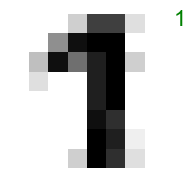

In [3]:
# simple function to plot the data
def plot_digit(digits, i):
    plt.figure(figsize=(2, 2))
    plt.imshow(digits.images[i], cmap='binary', interpolation='nearest')
    plt.text(8, 0.1, str(digits.target[i]), color='green', fontsize=16)
    plt.axis("off")
    
# always plot your data!
plot_digit(digits,1500)

## Principal Component Analysis (PCA)

Principal Component Analysis (PCA) is a method that finds the directions of maximum variance in high-dimensional data, then transforms the original data by projecting it in these directions. The principal components comprise a new orthogonal basis with vectors corresponding to these directions. Each principal component in turn accounts for progressively lesser variance, so often we can reduce the dimensionality of the data by keeping only the first several principal components.

For example, in the 2D dataset below, the first PC is along the trendline, and the second PC is orthogonal to it. The first PC is the green vector along which there is the most variance in the data.


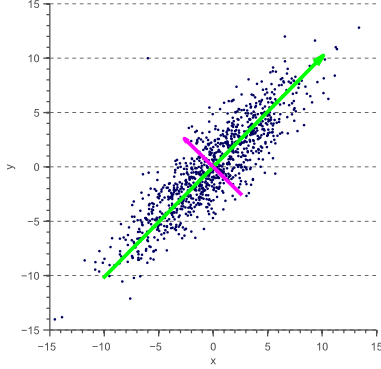

### Basic PCA Workflow for Dimensionality Reduction

**Note:** The explanation and cells that follow are here for completeness for those who are interested. No worries if not, just skim the next few cells and focus on the big picture rather than the mathematical details. `scikit-learn` provides built-in tools to for PCA so you can use it as a tool without worrying about the linear algebra.

The basic workflow for PCA is as follows:

1. Standardize (normalize) the feature vectors in the data. Whether or not it is necessary to standardize the data prior to a PCA on the covariance matrix depends on the measurement scales of the original features. Since PCA creates a coordinate system that maximizes the variance along each axes, it makes sense to standardize the data, especially, if it was measured on different scales. For example, if the first feature has units of miles but the second one has units of millimeters, the data will unlikely be on the same scale.
2. Obtain the eigenvectors and eigenvalues from the data covariance matrix.
3. Sort eigenvalues in descending order and choose the k eigenvectors that correspond to the k largest eigenvalues, where k is the number of dimensions of the new feature subspace (k≤d).
4. Construct the projection matrix W from the selected k eigenvectors.
5. Transform the original dataset X via W to obtain a k-dimensional feature subspace Y.


### Use linear algebra to apply PCA to the digits dataset

[Don't worry about the details here]

In [4]:
# Scale the data (the digits dataset doesn't really need this, but it's good practice)
X_std = StandardScaler().fit_transform(X_digits)
print(X_std.shape)

# Compute covariance matrix for digits dataset
cov_mat = np.cov(X_std.T)
print(cov_mat.shape)

# Obtain the Eigenvectors and Eigenvalues from the covariance matrix
eig_vals, eig_vecs = np.linalg.eig(cov_mat)
print(eig_vals.shape)
print(eig_vecs.shape)

(1797, 64)
(64, 64)
(64,)
(64, 64)


#### The common approach is to rank the eigenvalues from highest to lowest in order to choose the top k eigenvectors.

[Don't worry about the details here]

In [5]:
# Make a list of (eigenvalue, eigenvector) tuples sorted by decreasing eigenvalues
ksort = np.argsort(np.abs(eig_vals)) # argsort is for increasing order
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in ksort[::-1]] # decreasing order
print('There are',len(eig_pairs),'eigenvalues\n')

# Confirm that the list is correctly sorted by decreasing eigenvalues
print('Largest 5 Eigenvalues, in descending order:')
for i in eig_pairs[0:5]:
    print(i[0])
print('\n')
print('Smallest 5 Eigenvalues, in descending order:')
for i in eig_pairs[-5:]:
    print(i[0])

There are 64 eigenvalues

Largest 5 Eigenvalues, in descending order:
7.344776062836363
5.835490537329521
5.15396117641886
3.966235966587287
2.966345195093596


Smallest 5 Eigenvalues, in descending order:
0.06328961499153332
0.05037444015485384
0.0
0.0
0.0


#### The explained variance tells us how much information (variance) can be attributed to each of the principal components.

[Don't worry about the details here]

In [6]:
# Compute variance explained by each PC
tot = sum(eig_vals)
var_exp = [(i/tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

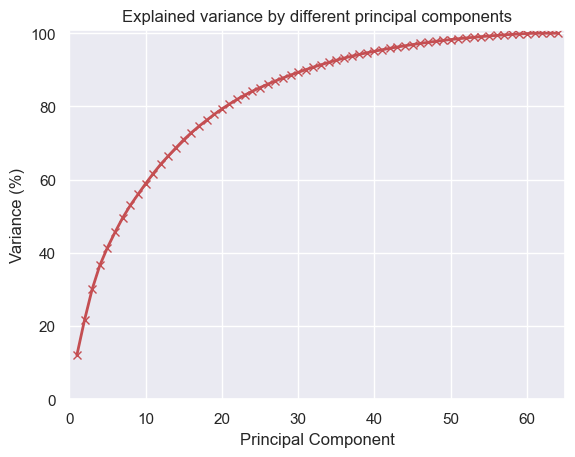

In [7]:
# How much variance is in each principal component?
pca_number = np.arange(1, len(var_exp) + 1)
plt.plot(pca_number, cum_var_exp, 'r-', lw=2)
plt.plot(pca_number, cum_var_exp, 'rx', lw=2)
plt.xlabel('Principal Component')
plt.ylabel('Variance (%)');
plt.xlim(0.0, len(var_exp)+1)
plt.ylim(0.0, 101.0)
plt.title('Explained variance by different principal components');

#### Dimensionality reduction exercise: compare original data with PCA-reduced data in a classification problem.

[Don't worry about the details here]

In [8]:
## First, reduce the data to the 20 largest PCs

# Compute the projection matrix for 20 principal components
matrix_w = np.hstack([eig_pairs[i][1].reshape(64,1) for i in range(20)])

# Project onto the new feature space
X_pca = X_digits.dot(matrix_w)

# Examine the size of original and new matrix
print(X_digits.shape, X_pca.shape)

(1797, 64) (1797, 20)


In [9]:
## Next, define training and testing data

# Train-test splits for original and reduced dataset
Xtrain_orig, Xtest_orig, ytrain_orig, ytest_orig = train_test_split(X_digits, y_digits, test_size=0.2, random_state=25)
Xtrain_pca, Xtest_pca, ytrain_pca, ytest_pca = train_test_split(X_pca, y_digits, test_size=0.2, random_state=25)

In [10]:
## Last, assess classifier performance

# Random forest classifiers
model_orig = RandomForestClassifier(n_estimators=500, random_state=10)
model_pca = RandomForestClassifier(n_estimators=500, random_state=100)

# Fit models to data
ymodel_orig = model_orig.fit(Xtrain_orig, ytrain_orig).predict(Xtest_orig)
ymodel_pca = model_pca.fit(Xtrain_pca, ytrain_pca).predict(Xtest_pca)

# Accuracy scores are similar
acc_orig=accuracy_score(ytest_orig, ymodel_orig)
acc_pca=accuracy_score(ytest_pca, ymodel_pca)
print('Prediction accuracy for the original dataset','{:.1%}'.format(acc_orig))
print('Prediction accuracy for the PCA dataset','{:.1%}'.format(acc_pca))

Prediction accuracy for the original dataset 96.9%
Prediction accuracy for the PCA dataset 96.1%


You can see that with the reduced dataset, our predictions are just as good. Moreover, the model is more computationally efficient and less like to risk overfitting (because it is less complex). PCA can thus be a useful preprocessing ("feature engineering") tool prior to running a supervised learning algorithm.

### Simplify this workflow with `sklearn`

The advantage of using `sklearn` for this is that we rapidly apply PCA to our data with less work and less math and no chance to make a coding mistake...

In [11]:
# scale the data (the digits dataset doesn't need this, but it's good practice)
X_digits_std = StandardScaler().fit_transform(X_digits)

#### We can specify PCA parameters by the number of components or the amount of variance reduction

In [12]:
# Calculate PCA that preserves 75% of the variance
digits_pca_75var = PCA(0.75)
digits_pca_75var.fit(X_digits_std)

PCA(n_components=0.75)

In [13]:
# How many components?
digits_pca_75var.n_components_

18

In [14]:
# We could also have used number of components
digits_pca_18 = PCA(18)

In [15]:
# How much variance is explained by each component?
print(digits_pca_75var.explained_variance_)

[7.34477606 5.83549054 5.15396118 3.96623597 2.9663452  2.57204442
 2.40600941 2.06867355 1.82993314 1.78951739 1.69784616 1.57287889
 1.38870781 1.35933609 1.32152536 1.16829176 1.08368678 0.99977862]


In [16]:
# What is cumulative variance ratio?
variance_75 = digits_pca_75var.explained_variance_ratio_
variance_ratio_75 = np.cumsum(np.round(variance_75, decimals=3)*100)
variance_ratio_75

array([12. , 21.6, 30. , 36.5, 41.4, 45.6, 49.5, 52.9, 55.9, 58.8, 61.6,
       64.2, 66.5, 68.7, 70.9, 72.8, 74.6, 76.2])

#### We often use the first two principal components to help visualize multi-dimensional data

In [17]:
# project from 64 to 2 dimensions
digits_pca2 = PCA(2)

# transform to 2 dimensions
digits_projected = digits_pca2.fit_transform(X_digits_std)

# create a dataframe
df_digits = pd.DataFrame(digits_projected, columns=['PCA1', 'PCA2'])  
df_digits["digit"] = digits.target
df_digits.head()

,PCA1,PCA2,digit
0,1.914212,-0.954475,0
1,0.588986,0.924619,1
2,1.302051,-0.317235,2
3,-3.020779,-0.868781,3
4,4.528950,-1.093481,4


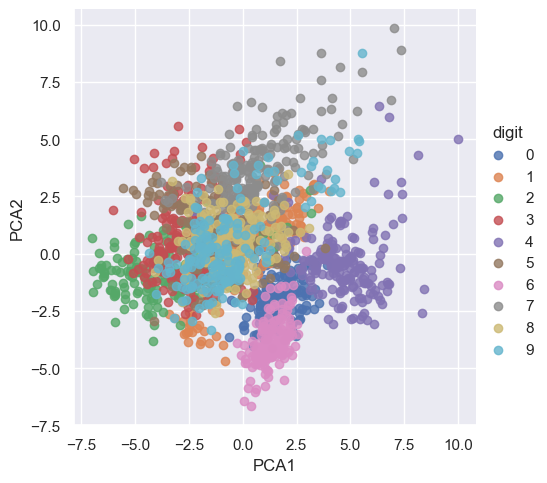

In [18]:
# seaborn lmplot
sns.lmplot(x="PCA1",y="PCA2", hue='digit', data=df_digits, fit_reg=False);

While the full data is a 64-dimensional point cloud, these points shown here are the projection of each data point along the two directions with the largest variance. In this light, PCA provides the "best" way to view the data in only two dimensions. With this representation, some digits become easy to distinguish (4 or 6). For others, we would need to go to higher dimensions (8 vs 9 for example).

## Clustering

Clustering is the task of identifying groups of data points that are similar in some way (i.e., close together in feature space. Here, the idea is to define clusters such that the data points in the same cluster are more similar to each other than to data points in other clusters.

### K-means clustering

This is a classic algorithm to find cluster centers that are representative of certain regions of the data. The algorithm alternates between two steps: 1) assigning each data point to the closest cluster center; 2) setting each cluster center as the mean of the data points that are assigned to it. The algorithm is iterative, finishing when the assignment of instances to clusters no longer changes. 


The cartoon I made below illustrates the concept:
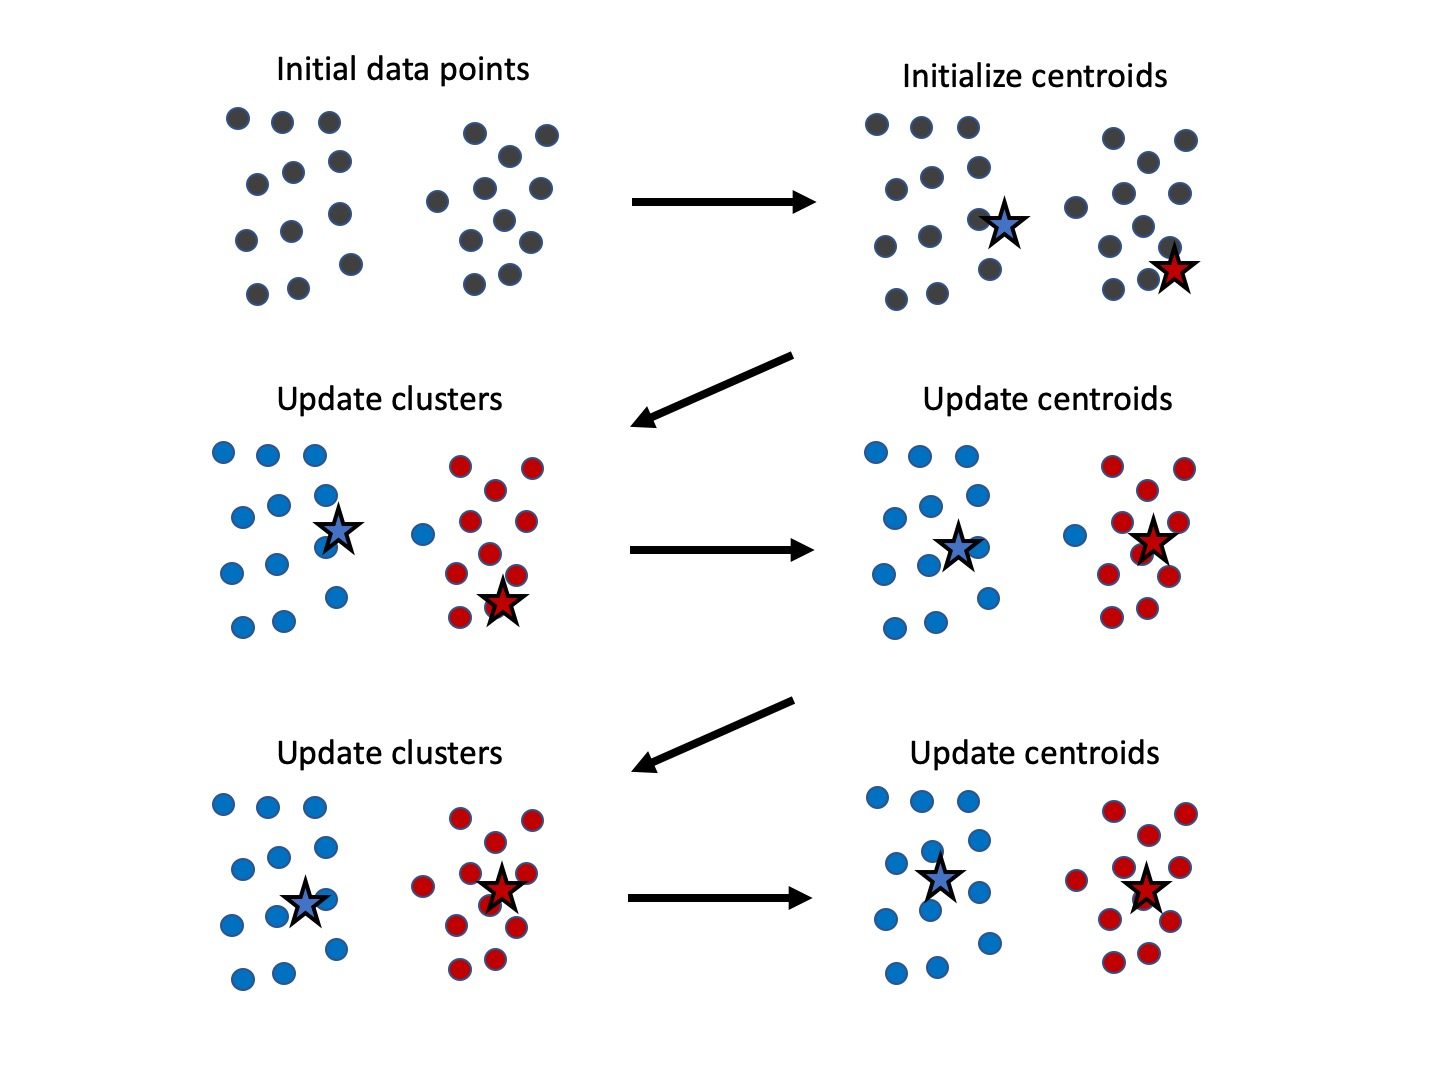

#### Generate some data to illustrate how K-means clustering works.

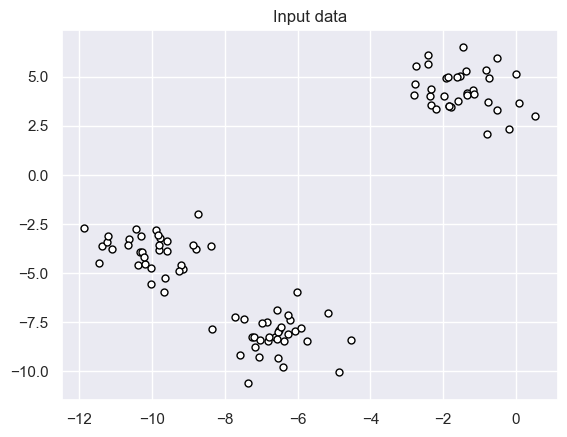

In [19]:
# Generate and plot data
X, y = make_blobs(random_state=1)
plt.plot(X[:, 0], X[:, 1], 'o', c='w',
    markeredgecolor='black', markeredgewidth=1, markersize=5)
plt.title("Input data");

#### K-Means Clustering examples

/Users/dtrugman/mambaforge/envs/pyclass24/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


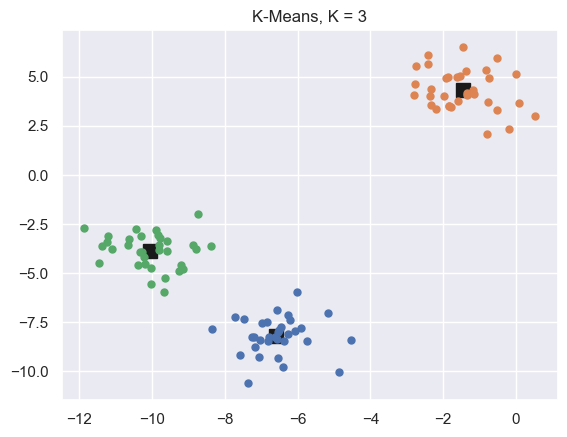

In [20]:
# Apply K-means with 3 clusters
km = KMeans(n_clusters=3).fit(X)
centers = km.cluster_centers_

# Plot updated dataset and clustering after iteration 1
labels = km.labels_
[plt.plot(val[0], val[1], 'ks', markersize=10) for val in centers]
for i in range(km.n_clusters):
    k = labels == i
    plt.plot(X[k,0], X[k,1], 'o', markersize=5)
plt.title("K-Means, K = %d" %km.n_clusters);

/Users/dtrugman/mambaforge/envs/pyclass24/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


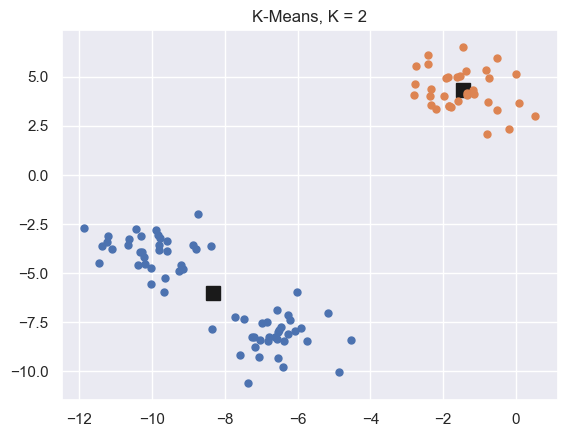

In [21]:
# Apply K-means with 2 clusters
km = KMeans(n_clusters=2).fit(X)
centers = km.cluster_centers_

# Plot updated dataset and clustering after iteration 1
labels = km.labels_
[plt.plot(val[0], val[1], 'ks', markersize=10) for val in centers]
for i in range(km.n_clusters):
    k = labels == i
    plt.plot(X[k,0], X[k,1], 'o', markersize=5)
plt.title("K-Means, K = %d" %km.n_clusters);

Often, we don't know the number of clusters a-priori. This is an example of a "hyperparameter" that you will need to consider in any clustering problem.

We'll discuss different strategies for this in a bit, but for now let's examine another case where the number of clusters is ambiguous:

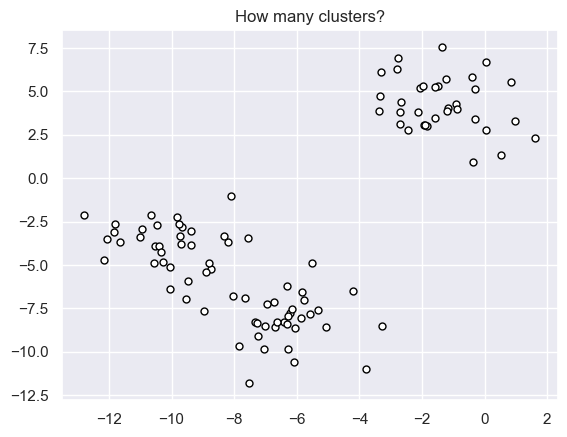

In [22]:
# Maybe harder
X, y = make_blobs(cluster_std=1.5, random_state=1)
plt.plot(X[:, 0], X[:, 1], 'o', c='w',
    markeredgecolor='black', markeredgewidth=1, markersize=5)
plt.title("How many clusters?");

/Users/dtrugman/mambaforge/envs/pyclass24/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


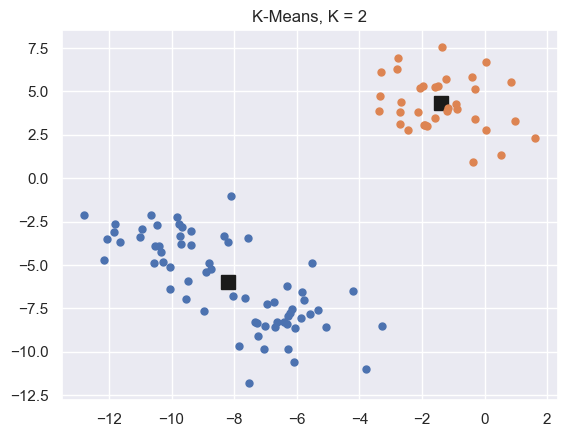

In [23]:
# Apply K-means: 2 cluster
km = KMeans(n_clusters=2).fit(X)
centers = km.cluster_centers_

# Plot dataset and clustering
labels = km.labels_
[plt.plot(val[0], val[1], 'ks', markersize=10) for val in centers]
for i in range(km.n_clusters):
    k = labels == i
    plt.plot(X[k,0], X[k,1], 'o', markersize=5)
plt.title("K-Means, K = %d" %km.n_clusters);

/Users/dtrugman/mambaforge/envs/pyclass24/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


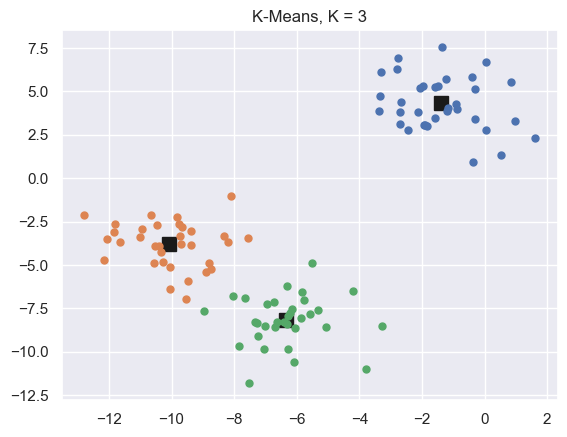

In [24]:
# Apply K-means: 3 cluster
km = KMeans(n_clusters=3).fit(X)
centers = km.cluster_centers_

# Plot dataset and clustering
labels = km.labels_
[plt.plot(val[0], val[1],'ks', markersize=10) for val in centers]
for i in range(km.n_clusters):
    k = labels == i
    plt.plot(X[k,0], X[k,1], 'o', markersize=5)
plt.title("K-Means, K = %d" %km.n_clusters);

/Users/dtrugman/mambaforge/envs/pyclass24/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


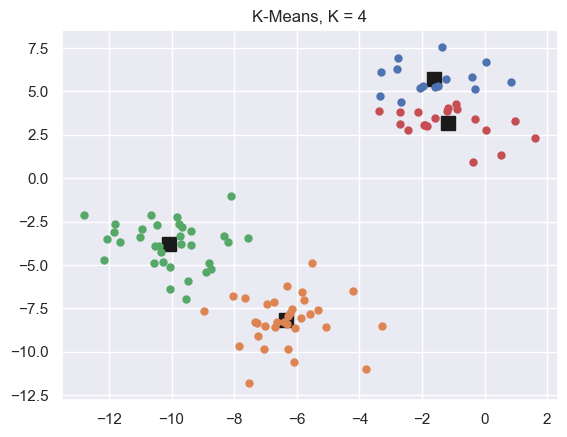

In [25]:
# Apply K-means: 4 cluster
km = KMeans(n_clusters=4).fit(X)
centers = km.cluster_centers_

# Plot updated dataset and clustering after iteration 1
labels = km.labels_
[plt.plot(val[0], val[1],'ks', markersize=10) for val in centers]
for i in range(km.n_clusters):
    k = labels == i
    plt.plot(X[k,0], X[k,1], 'o', markersize=5)
plt.title("K-Means, K = %d" %km.n_clusters);

## Other clustering algorithms.

There are many different clustering algorithms in `scikit-learn`, each with there own strengths and weaknesses. K-means works well if you have a good idea how many clusters you have a-priori, and if the clusters are relatively even in size.

But there are many other choices, as shown below. The handy thing is that they mostly follow the same fitting / processing recipe in `scikit-learn`, the differences come in selecting hyperparameters.

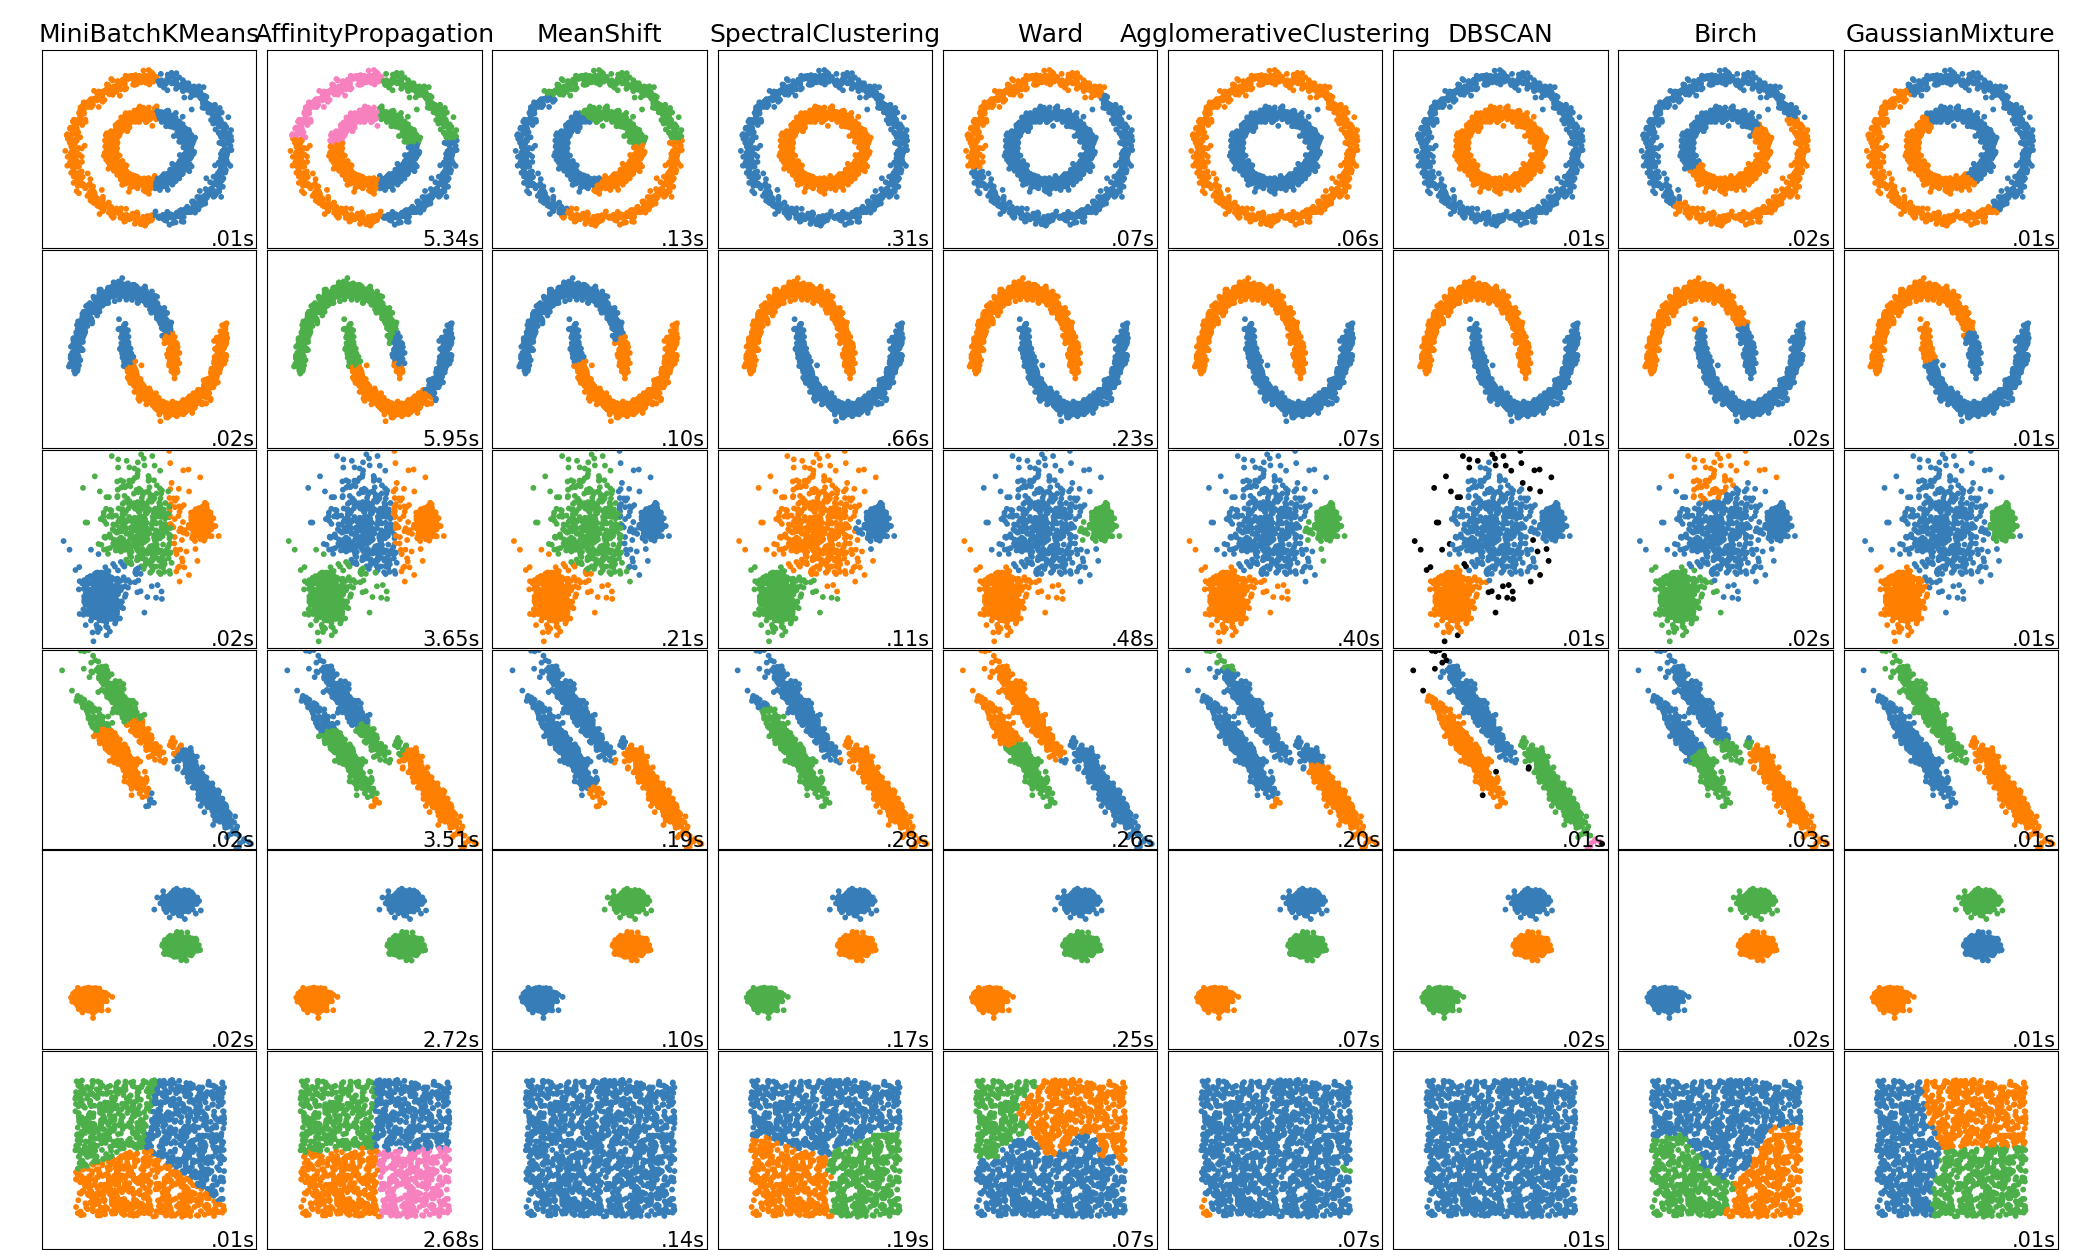

### Agglomerative Clustering
Agglomerative clustering is another commonly applied approach to clustering based on representing the dataset in a tree-like structure known as a hierarchy. In agglomerative (or "bottom-up") clustering, each data sample initially begins as its own cluster of one. The clustering algorithm then links clusters that are nearby in feature space, beginning with the nearest and proceeding through the entire dataset (in order of distance) until all of the samples comprise a single cluster. This procedure forms a hierarchical representation of the dataset, which can be truncated at different distance thresholds to partition the dataset into a desired number of clusters. For example, if we have 100 sample data points, the clustering algorithm will eventually link all 100 of these points together in a single cluster, but we can effectively terminate this procedure early to define any number of clusters from 1 to 100.

Graphically, agglomerative clustering works something like this:

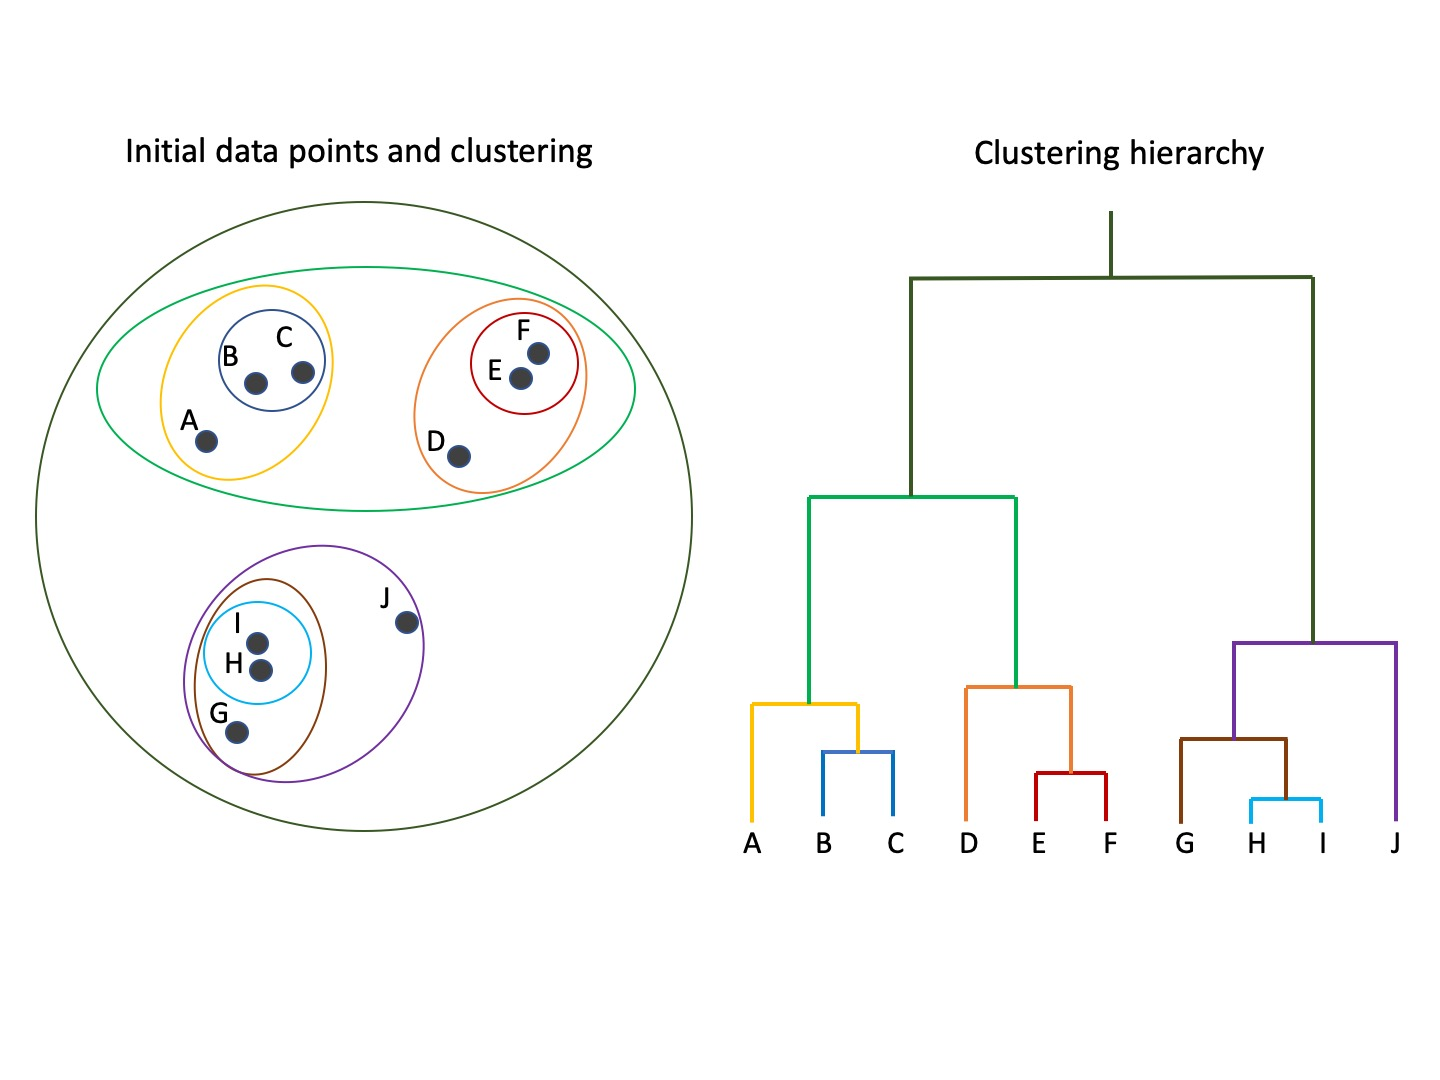

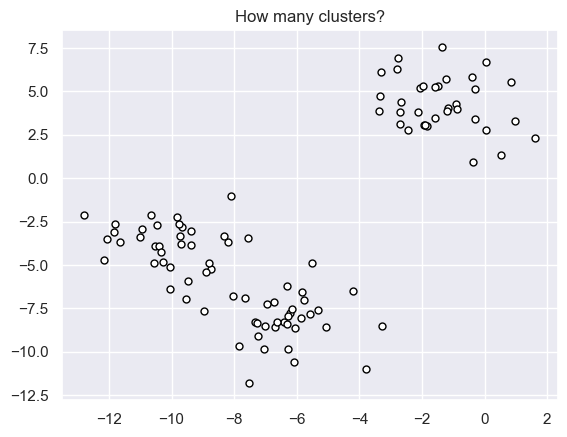

In [26]:
# Initialize data
X, y = make_blobs(cluster_std=1.5, random_state=1)
plt.plot(X[:, 0], X[:, 1], 'o', c='w',
    markeredgecolor='black', markeredgewidth=1, markersize=5)
plt.title("How many clusters?");

Just like in K-means, we can run Agglomerative Clustering with a specified number of clusters.

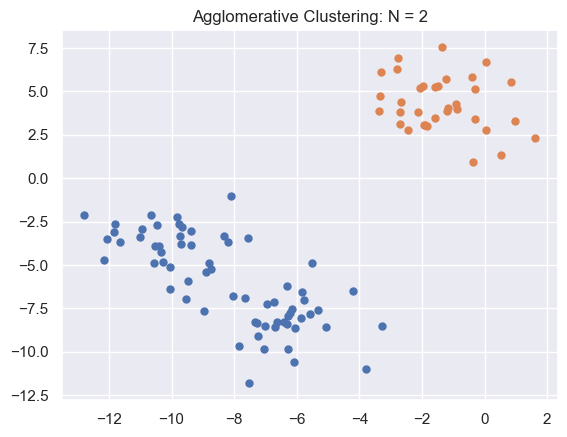

In [27]:
# Apply Agglomerative Clustering
ac = AgglomerativeClustering(n_clusters=2).fit(X)

# Plot dataset and clustering
labels = ac.labels_
for i in range(ac.n_clusters_):
    k = labels == i
    plt.plot(X[k,0], X[k,1], 'o', markersize=5)
plt.title("Agglomerative Clustering: N = " + str(ac.n_clusters));

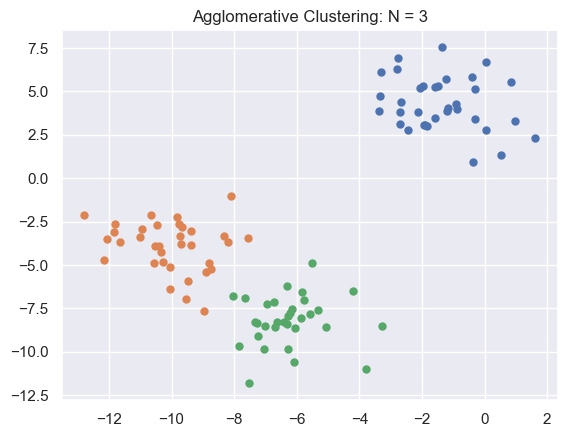

In [28]:
# Apply Agglomerative Clustering
ac = AgglomerativeClustering(n_clusters=3).fit(X)

# Plot dataset and clustering
labels = ac.labels_
for i in range(ac.n_clusters):
    k = labels == i
    plt.plot(X[k,0], X[k,1], 'o', markersize=5)
plt.title("Agglomerative Clustering: N = " + str(ac.n_clusters));

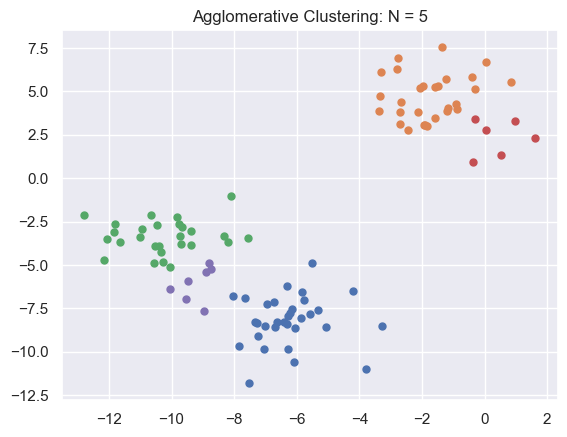

In [29]:
# Apply Agglomerative Clustering
ac = AgglomerativeClustering(n_clusters=5).fit(X)

# Plot dataset and clustering
labels = ac.labels_
for i in range(ac.n_clusters_):
    k = labels == i
    plt.plot(X[k,0], X[k,1], 'o', markersize=5)
plt.title("Agglomerative Clustering: N = " + str(ac.n_clusters));

One nice feature is that we can also have the number of clusters chosen automatically. To do this, we specify a distance threshold to determine the appropriate number of clusters. The distance threshold is a measure of "average" distance between clusters in this case, though there are other possible formulations (the "linkage" parameter).

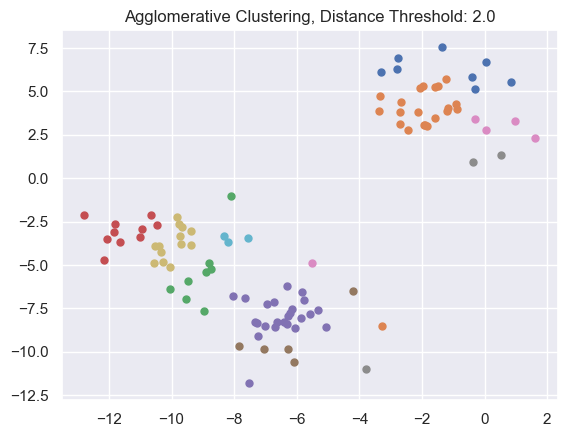

In [30]:
# Apply Agglomerative Clustering
ac = AgglomerativeClustering(n_clusters=None, distance_threshold=2, linkage="average").fit(X)

# Plot dataset and clustering
labels = ac.labels_
for i in range(ac.n_clusters_):
    k = labels == i
    plt.plot(X[k,0], X[k,1], 'o', markersize=5)
plt.title("Agglomerative Clustering, Distance Threshold: %.1f" %ac.distance_threshold);

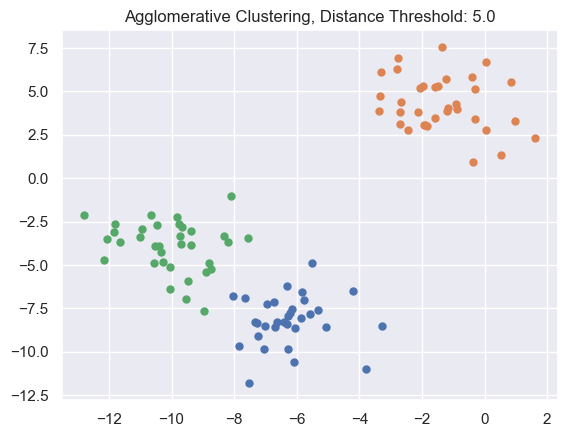

In [31]:
# Apply Agglomerative Clustering
ac = AgglomerativeClustering(n_clusters=None, distance_threshold=5, linkage="average").fit(X)

# Plot dataset and clustering
labels = ac.labels_
for i in range(ac.n_clusters_):
    k = labels == i
    plt.plot(X[k,0], X[k,1], 'o', markersize=5)
plt.title("Agglomerative Clustering, Distance Threshold: %.1f" %ac.distance_threshold);

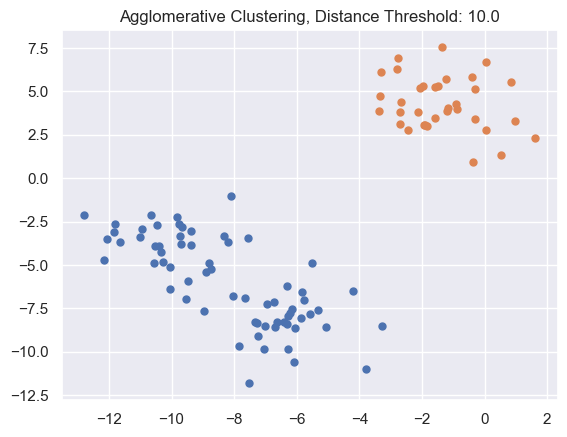

In [32]:
# Apply Agglomerative Clustering
ac = AgglomerativeClustering(n_clusters=None, distance_threshold=10, linkage="average").fit(X)

# Plot dataset and clustering
labels = ac.labels_
for i in range(ac.n_clusters_):
    k = labels == i
    plt.plot(X[k,0], X[k,1], 'o', markersize=5)
plt.title("Agglomerative Clustering, Distance Threshold: %.1f" %ac.distance_threshold);

### Another nice feature: we can visualize the clustering using a *dendrogram*.

[Don't worry about the code details below, just the concepts].

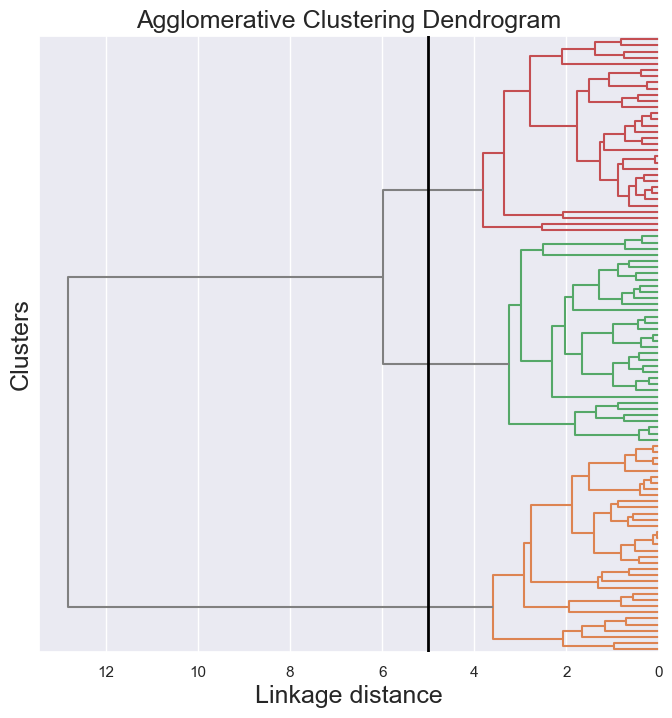

In [33]:
### Dendrogram Plot
from scipy.cluster.hierarchy import dendrogram, linkage

# Figure setup
fig, ax = plt.subplots(1, 1, figsize=(8,8))

## Compute linkage matrix between points
linkage_XX = linkage(X, method='average', metric='euclidean')

# Choose a cutoff distance and plot
cutoff_distance = 5.0
ax.plot([cutoff_distance, cutoff_distance], [0,1e15], '-', color='black', lw=2, zorder=1e3)

# Plot the dendogram, coloring each cluster
dd = dendrogram(linkage_XX, no_labels=True, ax=ax, orientation='left',
                color_threshold = cutoff_distance, above_threshold_color='gray')

# Format axis
ax.set_xlabel('Linkage distance',fontsize=18)
ax.set_ylabel('Clusters',fontsize=18)
plt.title('Agglomerative Clustering Dendrogram',fontsize=18)

# Show
plt.show()
plt.close()

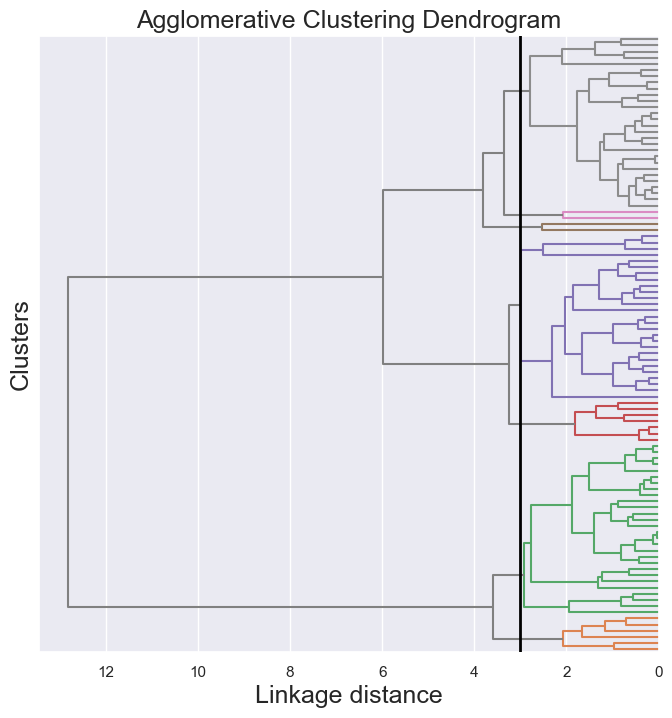

In [34]:
### Dendrogram Plot
from scipy.cluster.hierarchy import dendrogram, linkage

# Figure setup
fig, ax = plt.subplots(1, 1, figsize=(8,8))

## Compute linkage matrix between points
linkage_XX = linkage(X, method='average', metric='euclidean')

# Choose a cutoff distance and plot
cutoff_distance = 3.0
ax.plot([cutoff_distance, cutoff_distance], [0,1e15], '-', color='black', lw=2, zorder=1e3)

# Plot the dendogram, coloring each cluster
dd = dendrogram(linkage_XX, no_labels=True, ax=ax, orientation='left',
                color_threshold=cutoff_distance, above_threshold_color='gray')

# Format axis
ax.set_xlabel('Linkage distance', fontsize=18)
ax.set_ylabel('Clusters', fontsize=18)
plt.title('Agglomerative Clustering Dendrogram', fontsize=18)

# Show
plt.show()
plt.close()

### DBSCAN

In DBSCAN Clustering (Density-Based Spatial Clustering of Applications with Noise), we do not define ``n_clusters`` a priori. Instead, DBSCAN automatically determines the number of clusters based on two user-selected hyperparameters: the search radius ``eps`` and the minimum number of samples within this radius, ``min_samples``.

As you might anticipate given its name, DBSCAN is a density-based clustering algorithm that uses the density of points in feature space to identify clusters. Data samples in regions of high density are known as "core" points, which are fundamental to understanding how DBSCAN works. 

The basic algorithm can be summarized heuristically as follows:

0. Select algorithm hyperparameters ``eps`` and ``min_samples``.
1. For each sample data point, draw a sphere in feature space of radius ``eps`` and count the number of samples within this search radius.
2. If this number is greater than or equal to ``min_samples``, the center data point is defined to be a core point, essentially the nucleus of a new cluster containing all of the neighboring points within a radius ``eps``.
3. Loop through all sample points in the dataset, repeating steps 2 and 3 to form new clusters, and linking overlapping clusters (with mutual data points) where necessary.

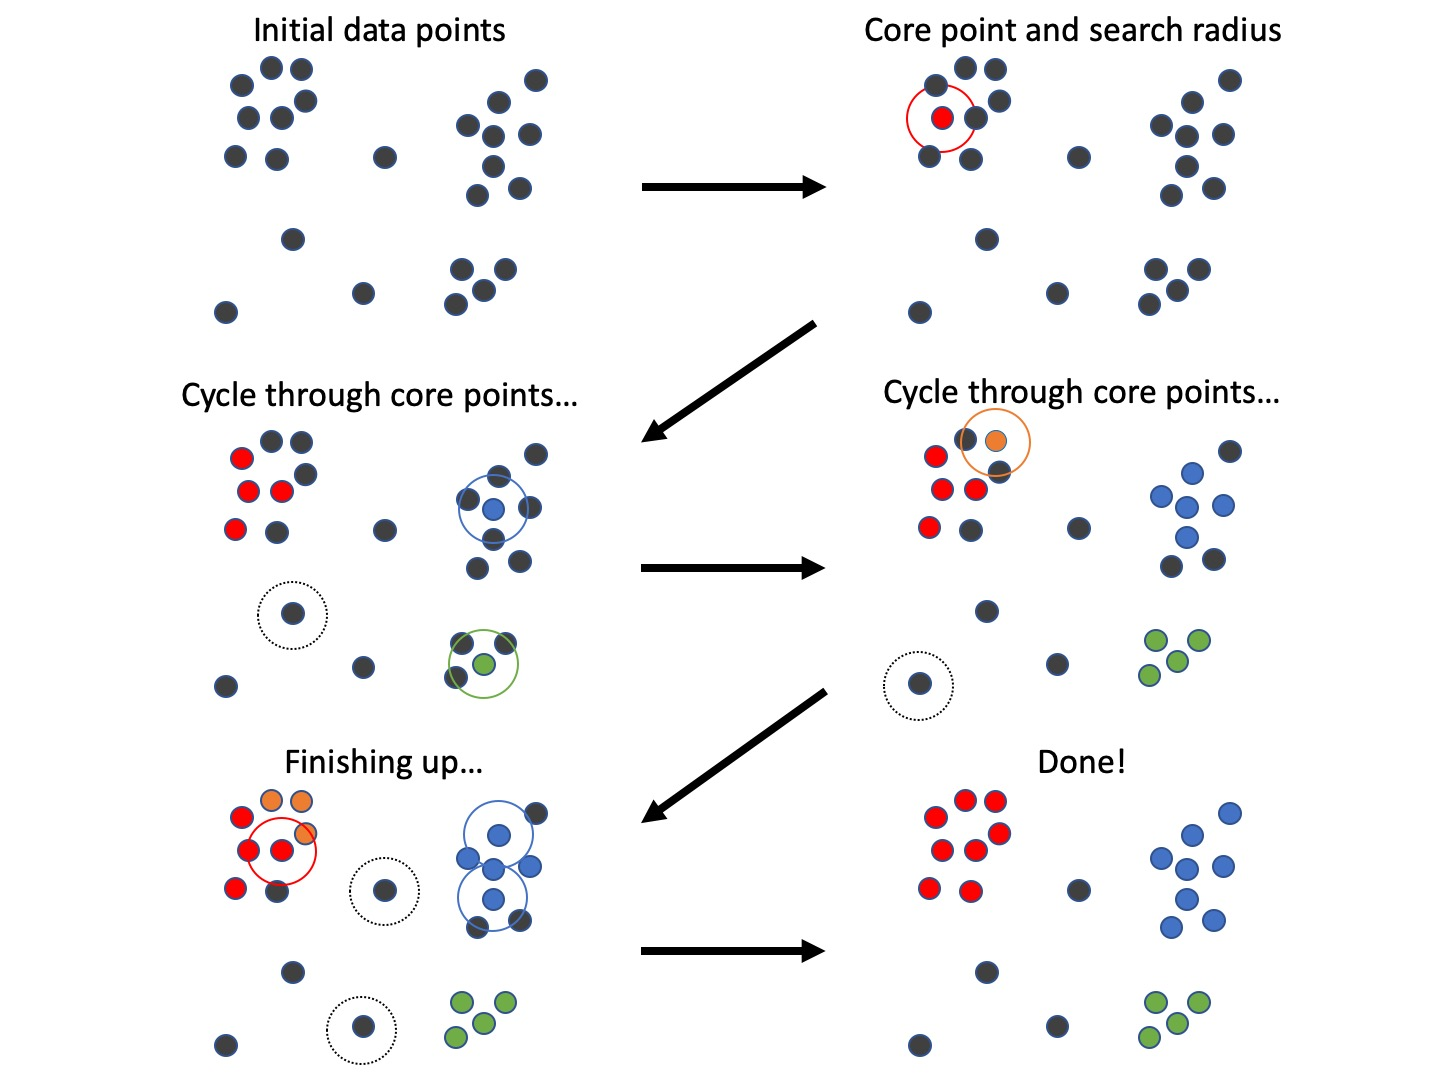

---

Note that in the procedure described aboved, sample data points in regions of low density will not be assigned to a cluster, and are termed "outlier" points. The presence of outlier data points also distinguishes ``DBSCAN`` from ``KMeans`` and ``AgglomerativeClustering``, in which each data point is assigned to one of the selected clusters. 



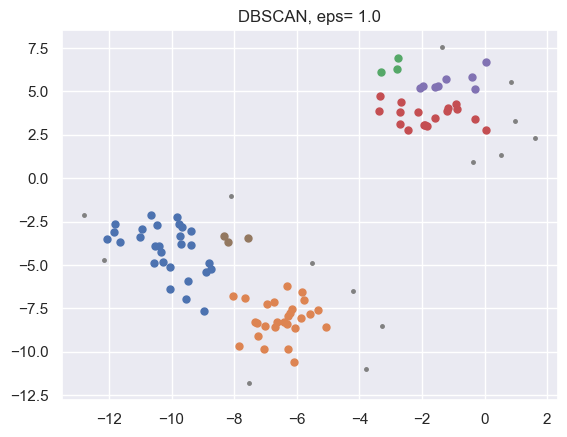

In [35]:
# Apply DBSCAN
db = DBSCAN(eps=1.0, min_samples=3).fit(X)

# Plot dataset and clustering
labels = db.labels_
nclust = np.max(labels)+1
for i in range(nclust):
    k = labels == i
    plt.plot(X[k,0], X[k,1], 'o', markersize=5)
    
# Plot outliers
k = labels < 0
plt.plot(X[k,0], X[k,1], '.', color="gray", markersize=5)
    
plt.title("DBSCAN, eps= %.1f" %db.eps);

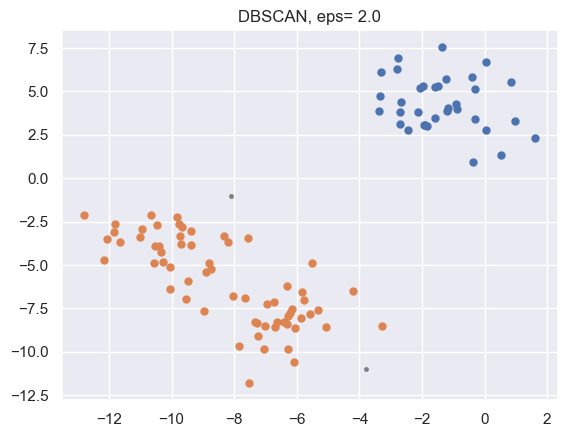

In [36]:
# Apply DBSCAN
db = DBSCAN(eps=2.0, min_samples=3).fit(X)

# Plot dataset and clustering
labels = db.labels_
nclust = np.max(labels) + 1
for i in range(nclust):
    k = labels == i
    plt.plot(X[k,0], X[k,1], 'o', markersize=5)
    
# Plot outliers
k = labels < 0
plt.plot(X[k,0], X[k,1],'.',color="gray",markersize=5)
    
plt.title("DBSCAN, eps= %.1f" %db.eps);

### Deciding how many clusters to choose: Silhouette Scores

This is a simple heuristic to chose the number of clusters for an algorithm like K-means.
The idea here is to try to balance the variance within clusters and distance between clusters. Conceptually, in a good clustering we will have small distances (variance) among points within a cluster and a large distance between points in two different clusters.

Higher silhouette scores are better in this case, so we are looking for the peak silhouette scores.

See: https://scikit-learn.org/stable/modules/clustering.html#silhouette-coefficient for details

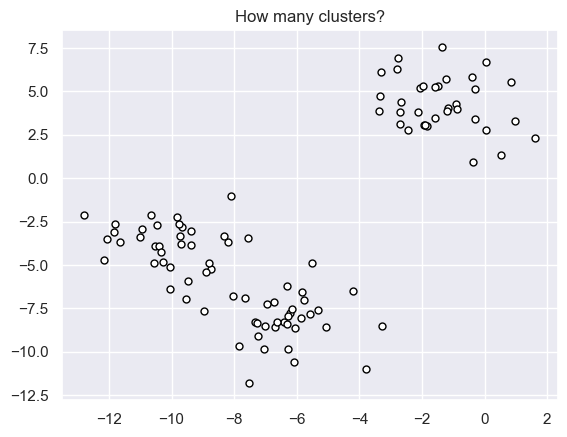

In [37]:
# Initialize data
X, y = make_blobs(cluster_std=1.5, random_state=1)
plt.plot(X[:, 0], X[:, 1], 'o', c='w',
    markeredgecolor='black', markeredgewidth=1,markersize=5)
plt.title("How many clusters?");

/Users/dtrugman/mambaforge/envs/pyclass24/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/dtrugman/mambaforge/envs/pyclass24/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/dtrugman/mambaforge/envs/pyclass24/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/dtrugman/mambaforge/envs/pyclass24/lib/python3.10/site-packages/sklearn/cluster/_kme

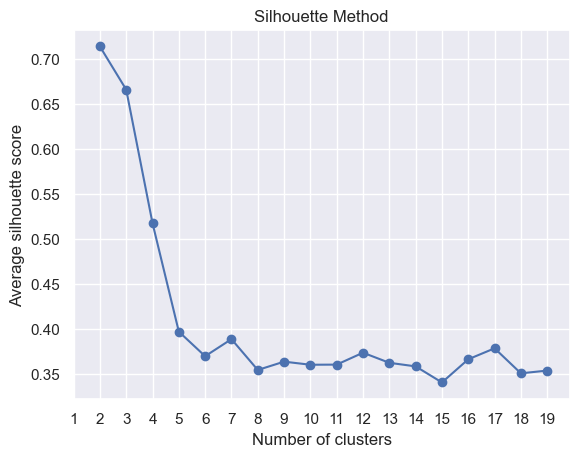

In [38]:
### Try a bunch of different clusterings
silscor=[]
for i in range(2, 20): # can't start at one here
    kmeans=KMeans(n_clusters = i)
    kmeans.fit(X)
    silscor.append(silhouette_score(X, kmeans.labels_))
    
# Plot results
plt.plot(range(2, 20), silscor,"-o")
plt.xticks(range(1, 20))
plt.title('Silhouette Method')
plt.xlabel('Number of clusters')
plt.ylabel('Average silhouette score' );

For this dataset, silhouette scores suggest that K=2 or K=3 are the best choices. Those two values have the highest scores, the other K values are much lower.

# Summary
* Unsupervised learning: used for dimensionality reduction or finding groupings within unlabeled data.
* PCA: used for dimensionality reduction, finds a new basis where the first PCs account for the most variance in the data.
* Clustering: used to find natural groups in a data.
* Algorithms include: K-Means, Agglomerative, DBSCAN.
* Different algorithms have different strengths and weaknesses.
* For algorithms like K-Means where you need to specify the number of clusters, one can try the silhouette score (or other analogous methods) for some guidance.